#NOTEBOOK FOR ACCESSING PROJECT DATA FROM NIH RePORTER API#

In [1]:
# Import necessary libraries

import requests
import pandas as pd
import numpy as np
import json

from IPython.display import display

!pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import requests

!pip install transformers
!pip install datasets
!pip install requests

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
!pip install huggingface-hub
import os

from tqdm import tqdm

##DEFINE ENDPOINTS AND RETRIEVAL PARAMETERS"

In [2]:
# Define the Base ApPI Endpoints

#Retreives projects against specified criteria payload
url = 'https://api.reporter.nih.gov/v2/projects/search'


In [3]:
#Define headers Parameter
headers = {'Content-Type': 'application/json'}

In [4]:
#Define Payload Parameter
payload = {
    "criteria": {
        "fiscal_years": [2023],
        "project_nums": ["R01"]
    },
    "include_fields": ["ProjectTitle", "ProjectNum", "PrincipalInvestigators", "Organization", "AwardAmount"],
    "offset": 0,
    "limit": 500 #max limit is 500
}

##OBTAIN AND SAVE DATA FROM API##

In [5]:
#Make the API Request:
response = requests.post(url, headers=headers, json=payload)
if response.status_code == 200:
    data = response.json()
else:
    print(f"Error: {response.status_code}")


In [6]:
#Process and Save the Data:

# Extract project data
projects = data.get('results', [])

# Convert to DataFrame
df = pd.DataFrame(projects)

# Save as CSV
df.to_csv('nih_projects.csv', index=False)

# Save as JSON
df.to_json('nih_projects.json', orient='records', lines=True)


In [7]:
# Display full DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



In [8]:
df.loc[0:1, :]

,project_num,organization,award_amount,principal_investigators,project_title
0,5R01NR018342-05,"{'org_name': 'BAYLOR COLLEGE OF MEDICINE', 'city': None, 'country': None, 'org_city': 'HOUSTON', 'org_country': 'UNITED STATES', 'org_state': 'TX', 'org_state_name': None, 'dept_type': 'INTERNAL MEDICINE/MEDICINE', 'fips_country_code': None, 'org_duns': ['051113330'], 'org_ueis': ['FXKMA43NTV21'], 'primary_duns': '051113330', 'primary_uei': 'FXKMA43NTV21', 'org_fips': 'US', 'org_ipf_code': '481201', 'org_zipcode': '770303411', 'external_org_id': 481201}",465252,"[{'profile_id': 8957751, 'first_name': 'Sara', 'middle_name': '', 'last_name': 'Nowakowski', 'is_contact_pi': True, 'full_name': 'Sara Nowakowski', 'title': 'ASSOCIATE PROFESSOR'}]",SleepHab: Effectiveness of Healthy Sleep Habits for Hospitalized Older Adults to Optimize Rehabilitation
1,5R01NR018335-05,"{'org_name': 'YALE UNIVERSITY', 'city': None, 'country': None, 'org_city': 'NEW HAVEN', 'org_country': 'UNITED STATES', 'org_state': 'CT', 'org_state_name': None, 'dept_type': 'INTERNAL MEDICINE/MEDICINE', 'fips_country_code': None, 'org_duns': ['043207562'], 'org_ueis': ['FL6GV84CKN57'], 'primary_duns': '043207562', 'primary_uei': 'FL6GV84CKN57', 'org_fips': 'US', 'org_ipf_code': '9420201', 'org_zipcode': '065208327', 'external_org_id': 9420201}",642567,"[{'profile_id': 1886491, 'first_name': 'Nancy', 'middle_name': 'S', 'last_name': 'Redeker', 'is_contact_pi': False, 'full_name': 'Nancy S Redeker', 'title': ''}, {'profile_id': 10337560, 'first_name': 'Kevin', 'middle_name': 'Navin', 'last_name': 'Sheth', 'is_contact_pi': False, 'full_name': 'Kevin Navin Sheth', 'title': 'ASSOCIATE PROFESSOR'}, {'profile_id': 9361200, 'first_name': 'Henry', 'middle_name': 'Klar', 'last_name': 'Yaggi', 'is_contact_pi': True, 'full_name': 'Henry Klar Yaggi', 'title': 'DIRECTOR YALE CENTERS FOR SLEEP MEDICINE'}]",The Recovery in Stroke Using PAP (RISE UP) Study


## DATA CLEANING AND PREPARATION ##

In [9]:
# Data Cleaning and Preparation

#Function to expand dictionary column in DataFrame
#source -  https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas/64563986#64563986


def expand_dataframe(dw: pd.DataFrame, column_to_expand: str) -> pd.DataFrame:
    """
    Expand a column containing dictionaries or lists of dictionaries into separate columns.

    Args:
    dw (pd.DataFrame): The original DataFrame.
    column_to_expand (str): The name of the column to expand.

    Returns:
    pd.DataFrame: The DataFrame with the expanded columns.
    """
    if dw[column_to_expand].apply(lambda x: isinstance(x, list)).any():
        # Expand lists of dictionaries
        expanded_rows = dw[column_to_expand].explode()  # Break lists into individual rows
        expanded_columns = expanded_rows.apply(pd.Series)  # Expand dictionary in each row
        expanded_dataframe = pd.concat([dw.drop(columns=[column_to_expand]).reset_index(drop=True),
                                         expanded_columns.reset_index(drop=True)], axis=1)
    else:
        # Expand single dictionaries
        expanded_dataframe = pd.concat([dw.drop(columns=[column_to_expand]),
                                         dw[column_to_expand].apply(pd.Series)], axis=1)
    return expanded_dataframe

# Test with both columns
columns_to_expand = ['principal_investigators', 'organization']

df_expanded = df.copy()

for col in columns_to_expand:
    if col in df_expanded.columns:
        df_expanded = expand_dataframe(df_expanded, col)

# Check the expanded DataFrame
df_expanded.head()


,project_num,award_amount,project_title,profile_id,first_name,middle_name,last_name,is_contact_pi,full_name,title,org_name,city,country,org_city,org_country,org_state,org_state_name,dept_type,fips_country_code,org_duns,org_ueis,primary_duns,primary_uei,org_fips,org_ipf_code,org_zipcode,external_org_id,0
0,5R01NR018342-05,465252.0,SleepHab: Effectiveness of Healthy Sleep Habits for Hospitalized Older Adults to Optimize Rehabilitation,8957751,Sara,,Nowakowski,True,Sara Nowakowski,ASSOCIATE PROFESSOR,BAYLOR COLLEGE OF MEDICINE,NaN,NaN,HOUSTON,UNITED STATES,TX,NaN,INTERNAL MEDICINE/MEDICINE,NaN,[051113330],[FXKMA43NTV21],051113330,FXKMA43NTV21,US,481201,770303411,481201.0,NaN
1,5R01NR018335-05,642567.0,The Recovery in Stroke Using PAP (RISE UP) Study,1886491,Nancy,S,Redeker,False,Nancy S Redeker,,YALE UNIVERSITY,NaN,NaN,NEW HAVEN,UNITED STATES,CT,NaN,INTERNAL MEDICINE/MEDICINE,NaN,[043207562],[FL6GV84CKN57],043207562,FL6GV84CKN57,US,9420201,065208327,9420201.0,NaN
2,5R01NR019275-03,475626.0,BREATHE: An efficacy-implementation trial of a brief shared decision making intervention among Black adults with uncontrolled Asthma in Federally Qualified Health Centers (FQHC).,10337560,Kevin,Navin,Sheth,False,Kevin Navin Sheth,ASSOCIATE PROFESSOR,COLUMBIA UNIVERSITY HEALTH SCIENCES,NaN,NaN,NEW YORK,UNITED STATES,NY,NaN,OTHER HEALTH PROFESSIONS,NaN,[621889815],[QHF5ZZ114M72],621889815,QHF5ZZ114M72,US,1833205,100323725,1833205.0,NaN
3,5R01NR019792-03,490432.0,The Impact of COVID-19 on End-of-Life Care for Vulnerable Populations,9361200,Henry,Klar,Yaggi,True,Henry Klar Yaggi,DIRECTOR YALE CENTERS FOR SLEEP MEDICINE,ICAHN SCHOOL OF MEDICINE AT MOUNT SINAI,NaN,NaN,NEW YORK,UNITED STATES,NY,NaN,INTERNAL MEDICINE/MEDICINE,NaN,[078861598],[C8H9CNG1VBD9],078861598,C8H9CNG1VBD9,US,3839801,100296574,3839801.0,NaN
4,5R01NR019831-02,773616.0,A Multisite Randomized Controlled Trial of EMPOWER for Family Surrogates of Critically Ill Patients,6771603,MAUREEN,,GEORGE,True,MAUREEN GEORGE,,WEILL MEDICAL COLL OF CORNELL UNIV,NaN,NaN,NEW YORK,UNITED STATES,NY,NaN,RADIATION-DIAGNOSTIC/ONCOLOGY,NaN,[060217502],[YNT8TCJH8FQ8],060217502,YNT8TCJH8FQ8,US,1514803,100654805,1514803.0,NaN


In [10]:
# Data Cleaning and Preparation

#Drop columns that only have NaN or missign values
df_cleaned = df_expanded.dropna(axis=1, how="all")

df_cleaned.head()

,project_num,award_amount,project_title,profile_id,first_name,middle_name,last_name,is_contact_pi,full_name,title,org_name,org_city,org_country,org_state,dept_type,org_duns,org_ueis,primary_duns,primary_uei,org_fips,org_ipf_code,org_zipcode,external_org_id
0,5R01NR018342-05,465252.0,SleepHab: Effectiveness of Healthy Sleep Habits for Hospitalized Older Adults to Optimize Rehabilitation,8957751,Sara,,Nowakowski,True,Sara Nowakowski,ASSOCIATE PROFESSOR,BAYLOR COLLEGE OF MEDICINE,HOUSTON,UNITED STATES,TX,INTERNAL MEDICINE/MEDICINE,[051113330],[FXKMA43NTV21],051113330,FXKMA43NTV21,US,481201,770303411,481201.0
1,5R01NR018335-05,642567.0,The Recovery in Stroke Using PAP (RISE UP) Study,1886491,Nancy,S,Redeker,False,Nancy S Redeker,,YALE UNIVERSITY,NEW HAVEN,UNITED STATES,CT,INTERNAL MEDICINE/MEDICINE,[043207562],[FL6GV84CKN57],043207562,FL6GV84CKN57,US,9420201,065208327,9420201.0
2,5R01NR019275-03,475626.0,BREATHE: An efficacy-implementation trial of a brief shared decision making intervention among Black adults with uncontrolled Asthma in Federally Qualified Health Centers (FQHC).,10337560,Kevin,Navin,Sheth,False,Kevin Navin Sheth,ASSOCIATE PROFESSOR,COLUMBIA UNIVERSITY HEALTH SCIENCES,NEW YORK,UNITED STATES,NY,OTHER HEALTH PROFESSIONS,[621889815],[QHF5ZZ114M72],621889815,QHF5ZZ114M72,US,1833205,100323725,1833205.0
3,5R01NR019792-03,490432.0,The Impact of COVID-19 on End-of-Life Care for Vulnerable Populations,9361200,Henry,Klar,Yaggi,True,Henry Klar Yaggi,DIRECTOR YALE CENTERS FOR SLEEP MEDICINE,ICAHN SCHOOL OF MEDICINE AT MOUNT SINAI,NEW YORK,UNITED STATES,NY,INTERNAL MEDICINE/MEDICINE,[078861598],[C8H9CNG1VBD9],078861598,C8H9CNG1VBD9,US,3839801,100296574,3839801.0
4,5R01NR019831-02,773616.0,A Multisite Randomized Controlled Trial of EMPOWER for Family Surrogates of Critically Ill Patients,6771603,MAUREEN,,GEORGE,True,MAUREEN GEORGE,,WEILL MEDICAL COLL OF CORNELL UNIV,NEW YORK,UNITED STATES,NY,RADIATION-DIAGNOSTIC/ONCOLOGY,[060217502],[YNT8TCJH8FQ8],060217502,YNT8TCJH8FQ8,US,1514803,100654805,1514803.0


In [11]:
# Data Cleaning and Preparation

#Drop duplicate columns "org_duns", "org_ueis", "external_org_id", "full_name"		for[ primary_duns, primary_uei	or, org_ipf_code, first_name middle_name last_name]


columns_to_drop = ["org_duns", "org_ueis", "external_org_id", "full_name"]
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Verify the changes
df_cleaned.head()


,project_num,award_amount,project_title,profile_id,first_name,middle_name,last_name,is_contact_pi,title,org_name,org_city,org_country,org_state,dept_type,primary_duns,primary_uei,org_fips,org_ipf_code,org_zipcode
0,5R01NR018342-05,465252.0,SleepHab: Effectiveness of Healthy Sleep Habits for Hospitalized Older Adults to Optimize Rehabilitation,8957751,Sara,,Nowakowski,True,ASSOCIATE PROFESSOR,BAYLOR COLLEGE OF MEDICINE,HOUSTON,UNITED STATES,TX,INTERNAL MEDICINE/MEDICINE,051113330,FXKMA43NTV21,US,481201,770303411
1,5R01NR018335-05,642567.0,The Recovery in Stroke Using PAP (RISE UP) Study,1886491,Nancy,S,Redeker,False,,YALE UNIVERSITY,NEW HAVEN,UNITED STATES,CT,INTERNAL MEDICINE/MEDICINE,043207562,FL6GV84CKN57,US,9420201,065208327
2,5R01NR019275-03,475626.0,BREATHE: An efficacy-implementation trial of a brief shared decision making intervention among Black adults with uncontrolled Asthma in Federally Qualified Health Centers (FQHC).,10337560,Kevin,Navin,Sheth,False,ASSOCIATE PROFESSOR,COLUMBIA UNIVERSITY HEALTH SCIENCES,NEW YORK,UNITED STATES,NY,OTHER HEALTH PROFESSIONS,621889815,QHF5ZZ114M72,US,1833205,100323725
3,5R01NR019792-03,490432.0,The Impact of COVID-19 on End-of-Life Care for Vulnerable Populations,9361200,Henry,Klar,Yaggi,True,DIRECTOR YALE CENTERS FOR SLEEP MEDICINE,ICAHN SCHOOL OF MEDICINE AT MOUNT SINAI,NEW YORK,UNITED STATES,NY,INTERNAL MEDICINE/MEDICINE,078861598,C8H9CNG1VBD9,US,3839801,100296574
4,5R01NR019831-02,773616.0,A Multisite Randomized Controlled Trial of EMPOWER for Family Surrogates of Critically Ill Patients,6771603,MAUREEN,,GEORGE,True,,WEILL MEDICAL COLL OF CORNELL UNIV,NEW YORK,UNITED STATES,NY,RADIATION-DIAGNOSTIC/ONCOLOGY,060217502,YNT8TCJH8FQ8,US,1514803,100654805


In [12]:
# Data Cleaning and Preparation

# Check columns for data types
print(df_cleaned.dtypes)


#count missing values in DataFrame
total_missing = df_cleaned.isna().sum().sum()

print(f"\n\nThere is {total_missing} missing data in the original DataFrame")



#count missing values in 'award_amount'  feature
award_amount_missing = df_cleaned['award_amount'].isna().sum().sum()

print(f"\n\nThere is {award_amount_missing} missing data in the award_amount feature")


project_num       object
award_amount     float64
project_title     object
profile_id         int64
first_name        object
middle_name       object
last_name         object
is_contact_pi       bool
title             object
org_name          object
org_city          object
org_country       object
org_state         object
dept_type         object
primary_duns      object
primary_uei       object
org_fips          object
org_ipf_code      object
org_zipcode       object
dtype: object


There is 2515 missing data in the original DataFrame


There is 185 missing data in the award_amount feature


In [13]:
# Data Cleaning and Preparation

# Observations with an award_amount of zero


print(f"These are observations with a missing award amount:\n")

df_cleaned[df_cleaned['award_amount'].isna()].head(4)


These are observations with a missing award amount:



,project_num,award_amount,project_title,profile_id,first_name,middle_name,last_name,is_contact_pi,title,org_name,org_city,org_country,org_state,dept_type,primary_duns,primary_uei,org_fips,org_ipf_code,org_zipcode
500,NaN,NaN,NaN,14901616,Francisco,J,Alvarado,True,ASSISTANT PROFESSOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501,NaN,NaN,NaN,14295511,Eric,Andrew,Appel,True,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502,NaN,NaN,NaN,1910828,Jennifer,A,Kearney,True,ASSOCIATE PROFESSOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,NaN,NaN,NaN,7639031,CHARLES,H.,SPRUCK,True,ASSISTANT PROFESSOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Data Cleaning and Preparation

# Remove observations with an award_amount of zero

df_cleaned = df_cleaned.dropna(subset = ['award_amount'])


#recount missing values in 'award_amount'  feature
award_amount_missing = df_cleaned['award_amount'].isna().sum().sum()

print(f"\n\nThere is {award_amount_missing} missing data in the award_amount feature\n\n")






There is 0 missing data in the award_amount feature




In [15]:
# Data Cleaning and Preparation

# Convert all string columns to uppercase
df_cleaned = df_cleaned.applymap(lambda x: x.upper() if isinstance(x, str) else x)

df_cleaned.head(3)

<ipython-input-15-261eaa276578>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df_cleaned.applymap(lambda x: x.upper() if isinstance(x, str) else x)


,project_num,award_amount,project_title,profile_id,first_name,middle_name,last_name,is_contact_pi,title,org_name,org_city,org_country,org_state,dept_type,primary_duns,primary_uei,org_fips,org_ipf_code,org_zipcode
0,5R01NR018342-05,465252.0,SLEEPHAB: EFFECTIVENESS OF HEALTHY SLEEP HABITS FOR HOSPITALIZED OLDER ADULTS TO OPTIMIZE REHABILITATION,8957751,SARA,,NOWAKOWSKI,True,ASSOCIATE PROFESSOR,BAYLOR COLLEGE OF MEDICINE,HOUSTON,UNITED STATES,TX,INTERNAL MEDICINE/MEDICINE,051113330,FXKMA43NTV21,US,481201,770303411
1,5R01NR018335-05,642567.0,THE RECOVERY IN STROKE USING PAP (RISE UP) STUDY,1886491,NANCY,S,REDEKER,False,,YALE UNIVERSITY,NEW HAVEN,UNITED STATES,CT,INTERNAL MEDICINE/MEDICINE,043207562,FL6GV84CKN57,US,9420201,065208327
2,5R01NR019275-03,475626.0,BREATHE: AN EFFICACY-IMPLEMENTATION TRIAL OF A BRIEF SHARED DECISION MAKING INTERVENTION AMONG BLACK ADULTS WITH UNCONTROLLED ASTHMA IN FEDERALLY QUALIFIED HEALTH CENTERS (FQHC).,10337560,KEVIN,NAVIN,SHETH,False,ASSOCIATE PROFESSOR,COLUMBIA UNIVERSITY HEALTH SCIENCES,NEW YORK,UNITED STATES,NY,OTHER HEALTH PROFESSIONS,621889815,QHF5ZZ114M72,US,1833205,100323725


In [16]:
#Exploring the Data:
rows, cols = df_cleaned.shape
print(f"The DataFrame has {rows} observations and {cols} features\n\n")

#Sort by award amount descending and view top 5
award_amount = df_cleaned.sort_values(by="award_amount", ascending=False)
print(award_amount.head(5))




The DataFrame has 500 observations and 19 features


         project_num  award_amount  \
112  5R01AG058639-04     3532548.0   
241  5R01AG034962-10     3463466.0   
430  5R01AG066910-04     1962435.0   
496  5R01AG065554-04     1633157.0   
407  5R01HL157256-02     1521329.0   

                                                                                                                                          project_title  \
112        BRAIN-ICU-2 STUDY: BRINGING TO LIGHT THE RISK FACTORS AND INCIDENCE OF NEUROPSYCHOLOGICAL DYSFUNCTION (DEMENTIA) IN ICU SURVIVORS, 2ND STUDY   
241                                                                                                                   VANDERBILT MEMORY & AGING PROJECT   
430                                                                                                           THE POINTER NEUROVASCULAR ANCILLARY STUDY   
496                               SCHEDULED PROPHYLACTIC 6-HOURLY IV ACETAMINOPHEN TO PREVENT POST

## Exploratory Data Analysis (EDA) ##

In [17]:
# Summary statistics
summary_stats = df_cleaned['award_amount'].describe()



print(f"The mean award amount from the data is $54,8903.60. The max award amount is $3,532,548.00. The minimum award amount is $63,835.00.\nAnd the mediaan award amount is 51,7083.00.  Because the median is to the left of the mean it is expected\n that the data will be skewed to the right\n")
print("Summary Statistics:\n")
print(f"{summary_stats}\n\n")

df_cleaned['award_amount'].median()

The mean award amount from the data is $54,8903.60. The max award amount is $3,532,548.00. The minimum award amount is $63,835.00.
And the mediaan award amount is 51,7083.00.  Because the median is to the left of the mean it is expected
 that the data will be skewed to the right

Summary Statistics:

count    5.000000e+02
mean     5.490434e+05
std      2.778219e+05
min      1.000000e+00
25%      3.937048e+05
50%      5.164805e+05
75%      6.406740e+05
max      3.532548e+06
Name: award_amount, dtype: float64




516480.5

Inteqaurtile Range

In [18]:
# Interquartile Range (IQR)
Q1 = df_cleaned['award_amount'].quantile(0.25)
Q3 = df_cleaned['award_amount'].quantile(0.75)
IQR = Q3 - Q1

# Lower and Upper Limits for Outlier Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Any award amount outsid the Lower and upper Bound qualifies as an outlier.")
print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}\n\n")


Any award amount outsid the Lower and upper Bound qualifies as an outlier.
IQR: 246969.25
Lower Bound: 23250.875
Upper Bound: 1011127.875




Histogram with Density overlay

Density plot and histogram confirm right skew. However despite the skew the distribution of the award amount closely models a normal distribution



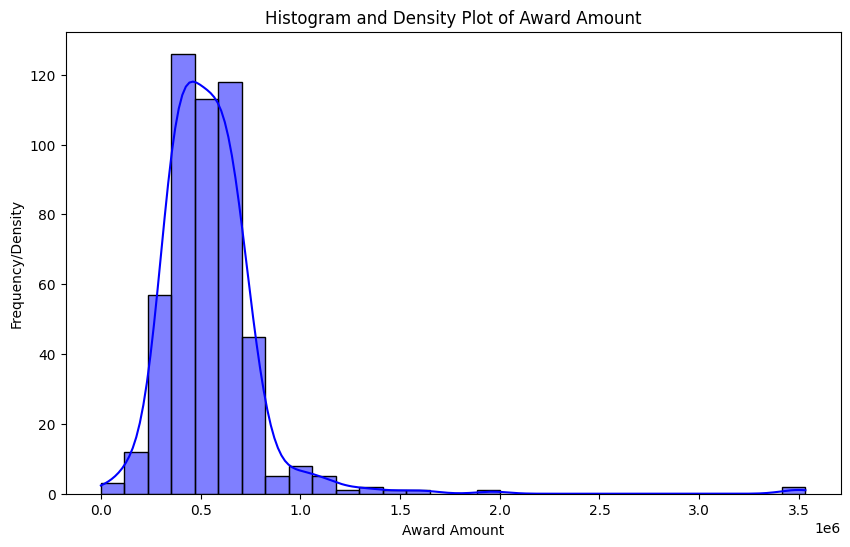

In [19]:
print(f"Density plot and histogram confirm right skew. However despite the skew the distribution of the award amount closely models a normal distribution\n")

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['award_amount'], kde=True, bins=30, color='blue')
plt.title("Histogram and Density Plot of Award Amount")
plt.xlabel("Award Amount")
plt.ylabel("Frequency/Density")
plt.show()




*Boxplot*

The box plot confirms the existence of several outlier vlaues to the right on the graph causing the right skew



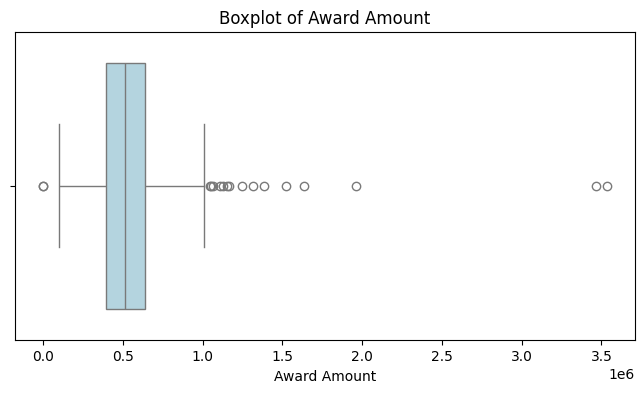

In [20]:
print(f"The box plot confirms the existence of several outlier vlaues to the right on the graph causing the right skew\n")

plt.figure(figsize=(8, 4))
sns.boxplot(x=df_cleaned['award_amount'], color='lightblue')
plt.title("Boxplot of Award Amount")
plt.xlabel("Award Amount")
plt.show()




Identifying Outliers

In [21]:
outliers = df_cleaned[(df_cleaned['award_amount'] < lower_bound) | (df_cleaned['award_amount'] > upper_bound)].sort_values("award_amount", ascending=False)
print("Outliers: Most of these outliers appear to involve projects addressing the effects of aging, including cognitive decline, neurological and chronic diseases, and efforts to slow or mitigate these effects.")
print("For the AI part of the project, I plan to submit these outliers and have the chat program analyze commonalities between them and explore reasons why they are funded at significantly higher levels than other projects. \n\n")

outliers


Outliers: Most of these outliers appear to involve projects addressing the effects of aging, including cognitive decline, neurological and chronic diseases, and efforts to slow or mitigate these effects.
For the AI part of the project, I plan to submit these outliers and have the chat program analyze commonalities between them and explore reasons why they are funded at significantly higher levels than other projects. 




,project_num,award_amount,project_title,profile_id,first_name,middle_name,last_name,is_contact_pi,title,org_name,org_city,org_country,org_state,dept_type,primary_duns,primary_uei,org_fips,org_ipf_code,org_zipcode
112,5R01AG058639-04,3532548.0,"BRAIN-ICU-2 STUDY: BRINGING TO LIGHT THE RISK FACTORS AND INCIDENCE OF NEUROPSYCHOLOGICAL DYSFUNCTION (DEMENTIA) IN ICU SURVIVORS, 2ND STUDY",12424232,MARC,,KOWALKOWSKI,True,ASSOCIATE PROFESSOR,VANDERBILT UNIVERSITY MEDICAL CENTER,NASHVILLE,UNITED STATES,TN,None,079917897,GYLUH9UXHDX5,US,10040927,372320011
241,5R01AG034962-10,3463466.0,VANDERBILT MEMORY & AGING PROJECT,15210146,ALON,,POLEG-POLSKY,True,ASSISTANT PROFESSOR,VANDERBILT UNIVERSITY MEDICAL CENTER,NASHVILLE,UNITED STATES,TN,None,079917897,GYLUH9UXHDX5,US,10040927,372320011
430,5R01AG066910-04,1962435.0,THE POINTER NEUROVASCULAR ANCILLARY STUDY,1886356,SHEY-SHING,,SHEU,False,,WAKE FOREST UNIVERSITY HEALTH SCIENCES,WINSTON-SALEM,UNITED STATES,NC,INTERNAL MEDICINE/MEDICINE,937727907,SN7KD2UK7GC5,US,9021205,271570001
496,5R01AG065554-04,1633157.0,SCHEDULED PROPHYLACTIC 6-HOURLY IV ACETAMINOPHEN TO PREVENT POSTOPERATIVE DELIRIUM IN OLDER CARDIAC SURGICAL PATIENTS,1889024,DOUGLAS,R,SEALS,True,DISTINGUISHED PROFESSOR,BETH ISRAEL DEACONESS MEDICAL CENTER,BOSTON,UNITED STATES,MA,None,071723621,C1CPANL3EWK4,US,758101,022155400
407,5R01HL157256-02,1521329.0,"POST-VENT, THE SEQUELAE: PERSONALIZED PROGNOSTIC MODELING FOR CONSEQUENCES OF NEONATAL INTERMITTENT HYPOXEMIA IN PRETERM INFANTS AT PRE-SCHOOL AGE",9331879,CATHARINE,LYNN,SMITH,True,ASSOCIATE PROFESSOR,LURIE CHILDREN'S HOSPITAL OF CHICAGO,CHICAGO,UNITED STATES,IL,None,074438755,XJ7MMPHBMGM7,US,1525701,606112991
438,5R01HL130974-06,1385234.0,CLINICAL GENETICS AND SCREENING FOR PULMONARY FIBROSIS,11155938,MANDY,J,MCGEACHY,True,ASSOCIATE PROFESSOR,BRIGHAM AND WOMEN'S HOSPITAL,BOSTON,UNITED STATES,MA,None,030811269,QN6MS4VN7BD1,US,1080401,021156110
256,5R01MH118382-04,1314937.0,PREVENTING SUICIDE IN AFRICAN AMERICAN ADOLESCENTS,9382941,INGRID,A,PRETZER-ABOFF,True,ASSOCIATE PROFESSOR,DE PAUL UNIVERSITY,CHICAGO,UNITED STATES,IL,PSYCHOLOGY,045694130,MNZ8KMRWTDB6,US,2052001,606042201
257,5R01MH120589-04,1249695.0,TARGETING COGNITION AND MOTIVATION IN COORDINATED SPECIALTY CARE FOR EARLY PSYCHOSIS,10791111,GANG,,ZHOU,False,,UNIVERSITY OF MINNESOTA,MINNEAPOLIS,UNITED STATES,MN,PSYCHIATRY,555917996,KABJZBBJ4B54,US,1450402,554552070
211,2R01ES021667-12,1165133.0,NEUROENDOCRINE COORDINATION OF MITOCHONDRIAL STRESS SIGNALING AND PROTEOSTASIS,1928273,JIL,C,TARDIFF,True,PROFESSSOR,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,UNITED STATES,CA,BIOCHEMISTRY,124726725,GS3YEVSS12N6,US,577502,947101749
314,5R01AI141202-05,1151780.0,CROSS-KINGDOM VACCINE TARGETING HEALTHCARE-ASSOCIATED PRIORITY PATHOGENS,1883300,JAN,,NOVAK,False,"MS, PHD",LUNDQUIST INSTITUTE FOR BIOMEDICAL INNOVATION AT HARBOR-UCLA MEDICAL CENTER,TORRANCE,UNITED STATES,CA,None,069926962,LTJVF4QSFCP9,US,2543101,905022006


Create Side-by-Side Boxplots

<ipython-input-23-33b3e0d2314d>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-23-33b3e0d2314d>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


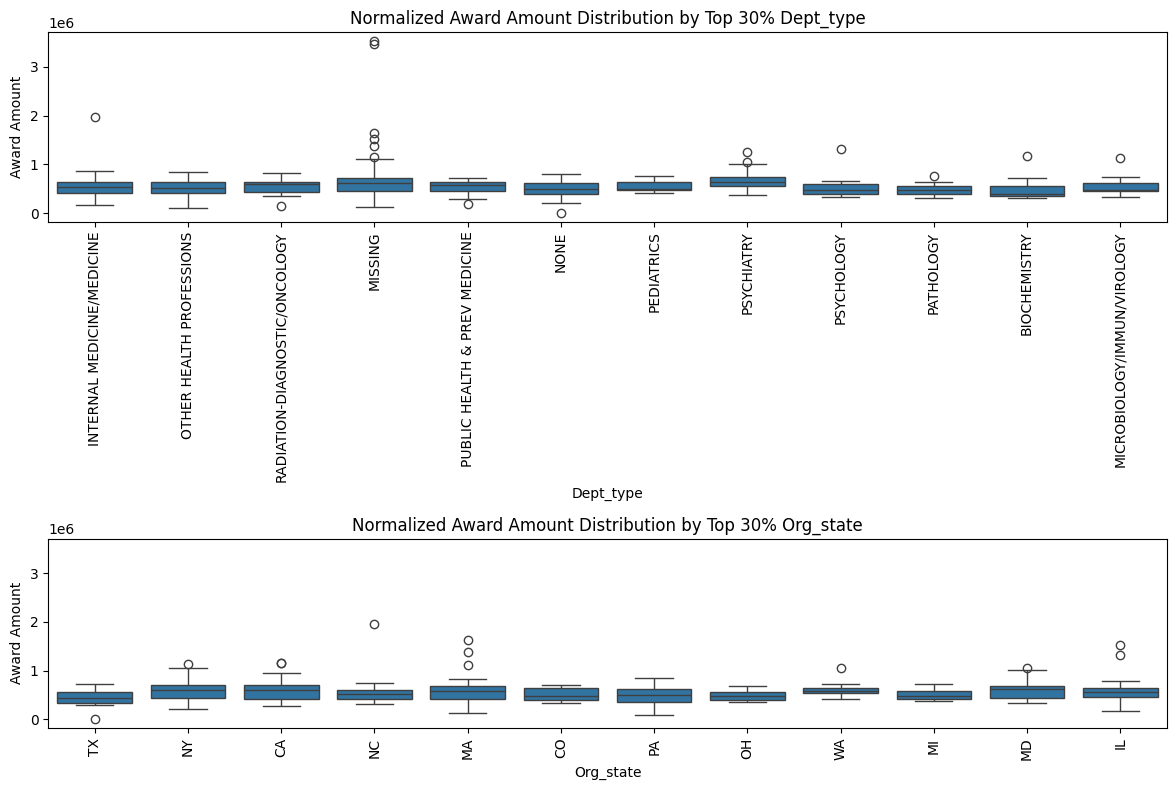

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace missing values in 'dept_type' and 'org_state' with 'MISSING'
df_cleaned['dept_type'] = df_cleaned['dept_type'].fillna('MISSING')
df_cleaned['org_state'] = df_cleaned['org_state'].fillna('MISSING')

# Variables to compare
categories = ['dept_type', 'org_state']

# Function to normalize and filter the top 30% of categories
def get_top_30_percent_normalized(df, category):
    proportions = df[category].value_counts(normalize=True)
    cutoff_index = int(len(proportions) * 0.3)
    top_30_percent = proportions[:cutoff_index].index
    filtered_df = df[df[category].isin(top_30_percent)]
    return filtered_df

# Normalize and filter top 30% for each category
filtered_dfs = {category: get_top_30_percent_normalized(df_cleaned, category) for category in categories}

# Create subplots for `dept_type` and `org_state`
fig, axes = plt.subplots(nrows=len(categories), ncols=1, figsize=(12, 8), sharey=True)

for ax, category in zip(axes, categories):
    filtered_df = filtered_dfs[category]
    sns.boxplot(data=filtered_df, x=category, y='award_amount', ax=ax)
    ax.set_title(f"Normalized Award Amount Distribution by Top 30% {category.capitalize()}")
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel("Award Amount")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


<ipython-input-45-706bd7f8396d>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-45-706bd7f8396d>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


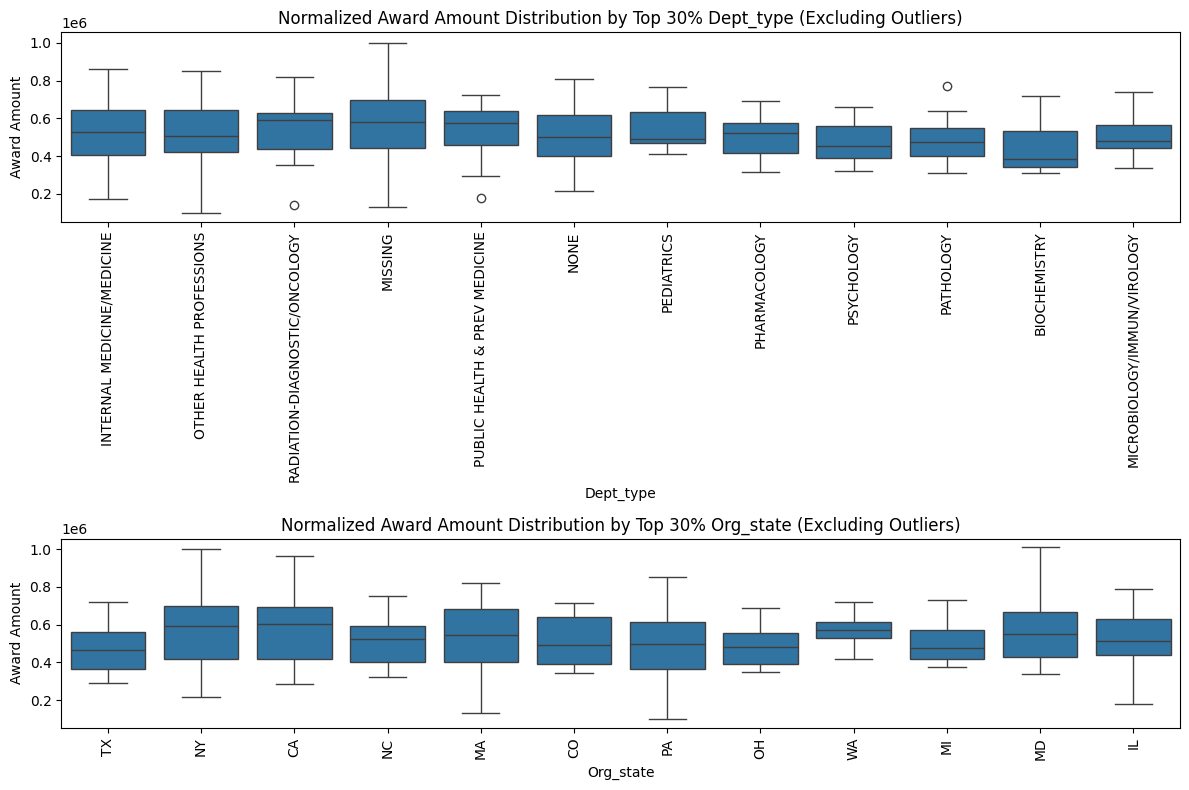

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace missing values in 'dept_type' and 'org_state' with 'MISSING'
df_cleaned['dept_type'] = df_cleaned['dept_type'].fillna('MISSING')
df_cleaned['org_state'] = df_cleaned['org_state'].fillna('MISSING')

# Function to calculate outlier boundaries using IQR
def calculate_outlier_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Step 1: Exclude outliers
lower_bound, upper_bound = calculate_outlier_bounds(df_cleaned, 'award_amount')
df_no_outliers = df_cleaned[(df_cleaned['award_amount'] >= lower_bound) &
                            (df_cleaned['award_amount'] <= upper_bound)]

# Step 2: Normalize and filter top 30% for each category
def get_top_30_percent_normalized(df, category):
    proportions = df[category].value_counts(normalize=True)
    cutoff_index = int(len(proportions) * 0.3)
    top_30_percent = proportions[:cutoff_index].index
    filtered_df = df[df[category].isin(top_30_percent)]
    return filtered_df

# Variables to compare
categories = ['dept_type', 'org_state']
filtered_dfs = {category: get_top_30_percent_normalized(df_no_outliers, category) for category in categories}

# Step 3: Create subplots for filtered data
fig, axes = plt.subplots(nrows=len(categories), ncols=1, figsize=(12, 8), sharey=True)

for ax, category in zip(axes, categories):
    filtered_df = filtered_dfs[category]
    sns.boxplot(data=filtered_df, x=category, y='award_amount', ax=ax)
    ax.set_title(f"Normalized Award Amount Distribution by Top 30% {category.capitalize()} (Excluding Outliers)")
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel("Award Amount")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


<ipython-input-44-e54b240276be>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_terms_df, x='Frequency', y='Term', palette='Blues_r')


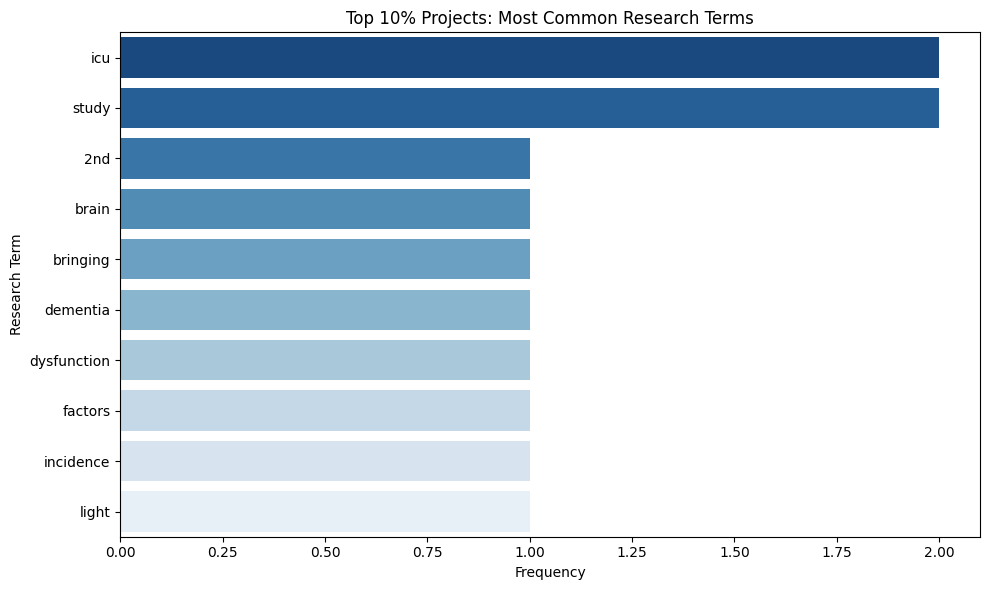

<ipython-input-44-e54b240276be>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_10, x='top_term', y='award_amount', palette='coolwarm')


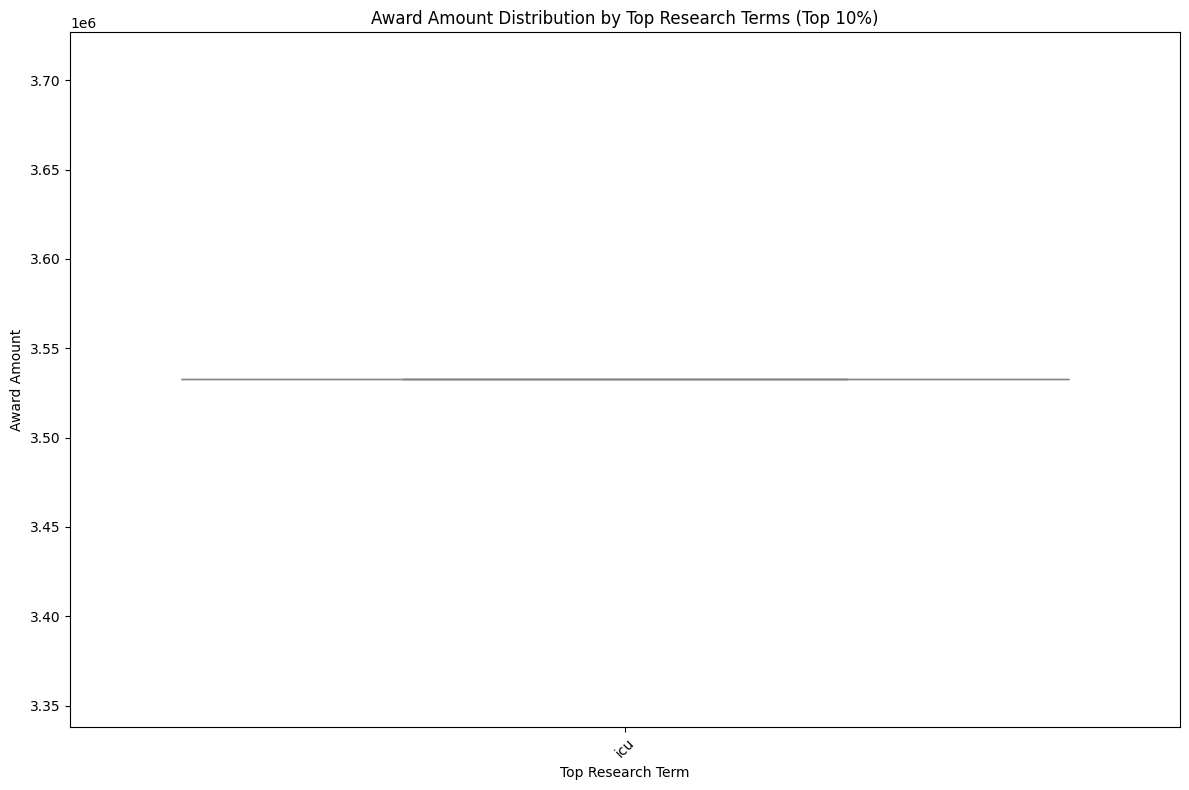

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Step 1: Sort by award amount and filter top 10%
top_10_percent_cutoff = int(len(outliers) * 0.1)  # Calculate the top 10% cutoff
df_top_10 = outliers.nlargest(top_10_percent_cutoff, 'award_amount').copy()

# Step 2: Combine and tokenize project titles
# Combine titles into a single string for processing
combined_titles = " ".join(df_top_10['project_title'].dropna())

# Tokenize and count term frequencies
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform([combined_titles])  # Single document containing all titles
terms = vectorizer.get_feature_names_out()
term_frequencies = Counter(dict(zip(terms, X.toarray()[0])))

# Extract the top terms
top_terms = term_frequencies.most_common(10)  # Adjust the number of terms if needed
top_terms_df = pd.DataFrame(top_terms, columns=['Term', 'Frequency'])

# Step 3: Visualize the most frequent terms
plt.figure(figsize=(10, 6))
sns.barplot(data=top_terms_df, x='Frequency', y='Term', palette='Blues_r')
plt.title("Top 10% Projects: Most Common Research Terms")
plt.xlabel("Frequency")
plt.ylabel("Research Term")
plt.tight_layout()
plt.show()

# Step 4: Compare award amounts for the top terms
# Assign each project to its most relevant term (simplified mapping for demonstration)
df_top_10['top_term'] = df_top_10['project_title'].apply(
    lambda title: next((term for term, _ in top_terms if term in title.lower()), 'Other')
)

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_10, x='top_term', y='award_amount', palette='coolwarm')
plt.title("Award Amount Distribution by Top Research Terms (Top 10%)")
plt.xlabel("Top Research Term")
plt.ylabel("Award Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-46-e4f413a7f4df>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-46-e4f413a7f4df>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


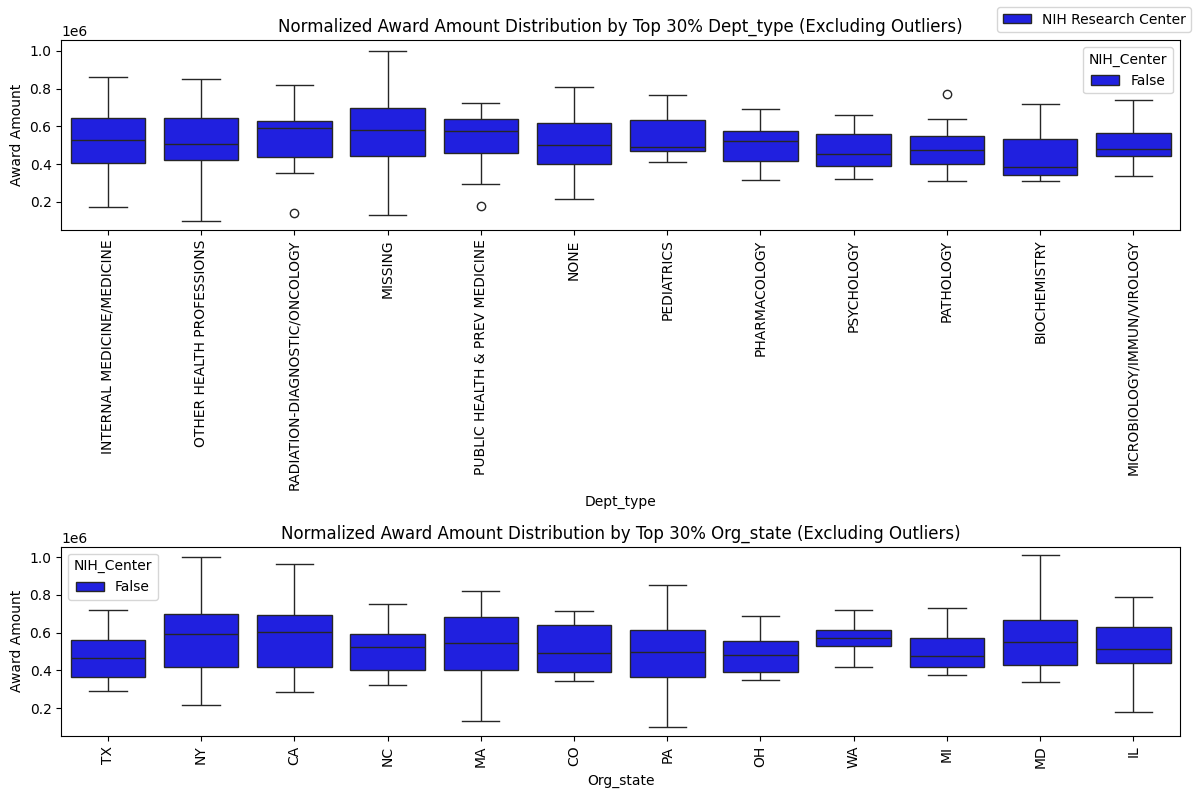

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace missing values in 'dept_type' and 'org_state' with 'MISSING'
df_cleaned['dept_type'] = df_cleaned['dept_type'].fillna('MISSING')
df_cleaned['org_state'] = df_cleaned['org_state'].fillna('MISSING')

# Step 1: Dynamically Identify NIH Research Center States
# Example source for NIH research states (replace with accurate data if available)
nih_research_states = [
    "Maryland", "North Carolina", "Montana", "Arizona",
    "Massachusetts", "California", "New York", "Michigan"
]

# Add a column indicating if a state hosts an NIH research center
df_cleaned['NIH_Center'] = df_cleaned['org_state'].str.upper().isin([state.upper() for state in nih_research_states])

# Step 2: Exclude outliers using IQR
def calculate_outlier_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower_bound, upper_bound = calculate_outlier_bounds(df_cleaned, 'award_amount')
df_no_outliers = df_cleaned[(df_cleaned['award_amount'] >= lower_bound) &
                            (df_cleaned['award_amount'] <= upper_bound)]

# Step 3: Normalize and filter top 30% for each category
def get_top_30_percent_normalized(df, category):
    proportions = df[category].value_counts(normalize=True)
    cutoff_index = int(len(proportions) * 0.3)
    top_30_percent = proportions[:cutoff_index].index
    filtered_df = df[df[category].isin(top_30_percent)]
    return filtered_df

categories = ['dept_type', 'org_state']
filtered_dfs = {category: get_top_30_percent_normalized(df_no_outliers, category) for category in categories}

# Step 4: Plot filtered data with NIH Research Center Highlight
fig, axes = plt.subplots(nrows=len(categories), ncols=1, figsize=(12, 8), sharey=True)

for ax, category in zip(axes, categories):
    filtered_df = filtered_dfs[category]
    sns.boxplot(data=filtered_df, x=category, y='award_amount', ax=ax,
                hue='NIH_Center', palette={True: 'green', False: 'blue'})
    ax.set_title(f"Normalized Award Amount Distribution by Top 30% {category.capitalize()} (Excluding Outliers)")
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel("Award Amount")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Add legend for NIH Research Centers
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['NIH Research Center', 'Other'], loc='upper right')

plt.tight_layout()
plt.show()


<ipython-input-60-6491d639afe0>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['Normalized_Award'] = df_top_10['award_amount'] / df_top_10['award_amount'].sum()


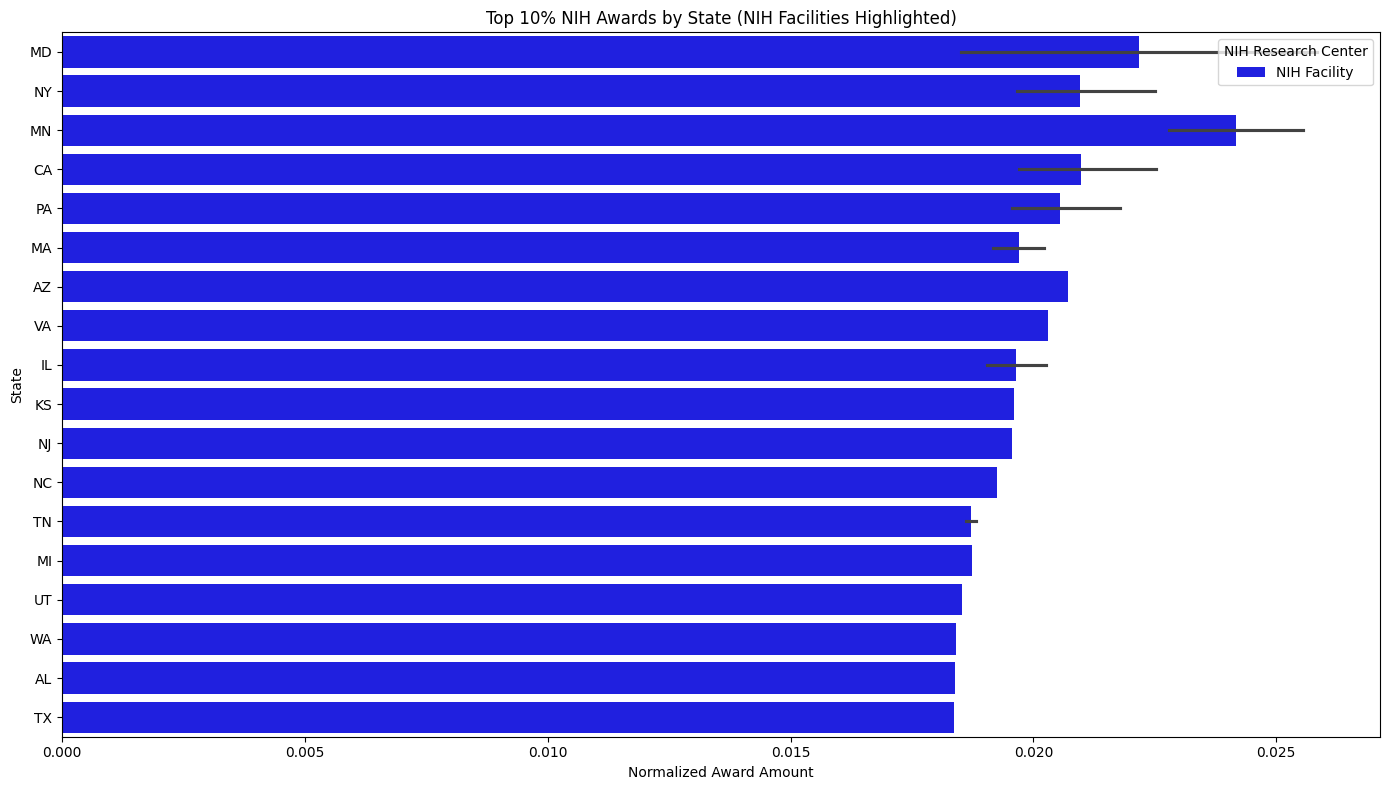

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace missing values in 'dept_type' and 'org_state' with 'MISSING'
df_cleaned['dept_type'] = df_cleaned['dept_type'].fillna('MISSING')
df_cleaned['org_state'] = df_cleaned['org_state'].fillna('MISSING')

# Step 1: Dynamically Identify NIH Research Center States
nih_research_states = [
    "Maryland", "North Carolina", "Montana", "Arizona",
    "Massachusetts", "California", "New York", "Michigan"
]

# Add a column indicating if a state hosts an NIH research center
df_cleaned['NIH_Center'] = df_cleaned['org_state'].str.upper().isin([state.upper() for state in nih_research_states])

# Step 2: Exclude outliers using IQR
def calculate_outlier_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower_bound, upper_bound = calculate_outlier_bounds(df_cleaned, 'award_amount')
df_no_outliers = df_cleaned[(df_cleaned['award_amount'] >= lower_bound) &
                            (df_cleaned['award_amount'] <= upper_bound)]

# Step 3: Filter for top 10% based on award amount
top_10_cutoff = df_no_outliers['award_amount'].quantile(0.9)
df_top_10 = df_no_outliers[df_no_outliers['award_amount'] >= top_10_cutoff]

# Step 4: Normalize award amounts for top 10% data
df_top_10['Normalized_Award'] = df_top_10['award_amount'] / df_top_10['award_amount'].sum()

# Step 5: Plot top 10% data with NIH Research Center Highlight
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_top_10.sort_values('Normalized_Award', ascending=False),
    x='Normalized_Award',
    y='org_state',
    hue='NIH_Center',
    dodge=False,
    palette={True: 'green', False: 'blue'}
)

# Customize the plot
plt.title("Top 10% NIH Awards by State (NIH Facilities Highlighted)")
plt.xlabel("Normalized Award Amount")
plt.ylabel("State")

# Fix the legend labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["NIH Facility", "Non-NIH Facility"], title="NIH Research Center", loc='upper right')

# Annotate NIH center states
for i, row in df_top_10.iterrows():
    if row['NIH_Center']:
        plt.text(
            i,
            row['Normalized_Award'] + 0.02,
            'NIH Facility',
            color='green',
            fontsize=10,
            ha='center'
        )

plt.tight_layout()
plt.show()


In [54]:
df_cleaned['org_state'].unique()


array(['TX', 'CT', 'NY', 'CA', 'NC', 'MA', 'GA', 'CO', 'FL', 'PA', 'OH',
       'AZ', 'MO', 'IN', 'WA', 'AR', 'AL', 'RI', 'MI', 'TN', 'UT', 'MD',
       'MN', 'VA', 'IA', 'IL', 'KS', 'OR', 'KY', 'LA', 'NJ', 'MISSING',
       'WI', 'DC', 'NM', 'PR', 'OK', 'SC', 'MS', 'NE'], dtype=object)

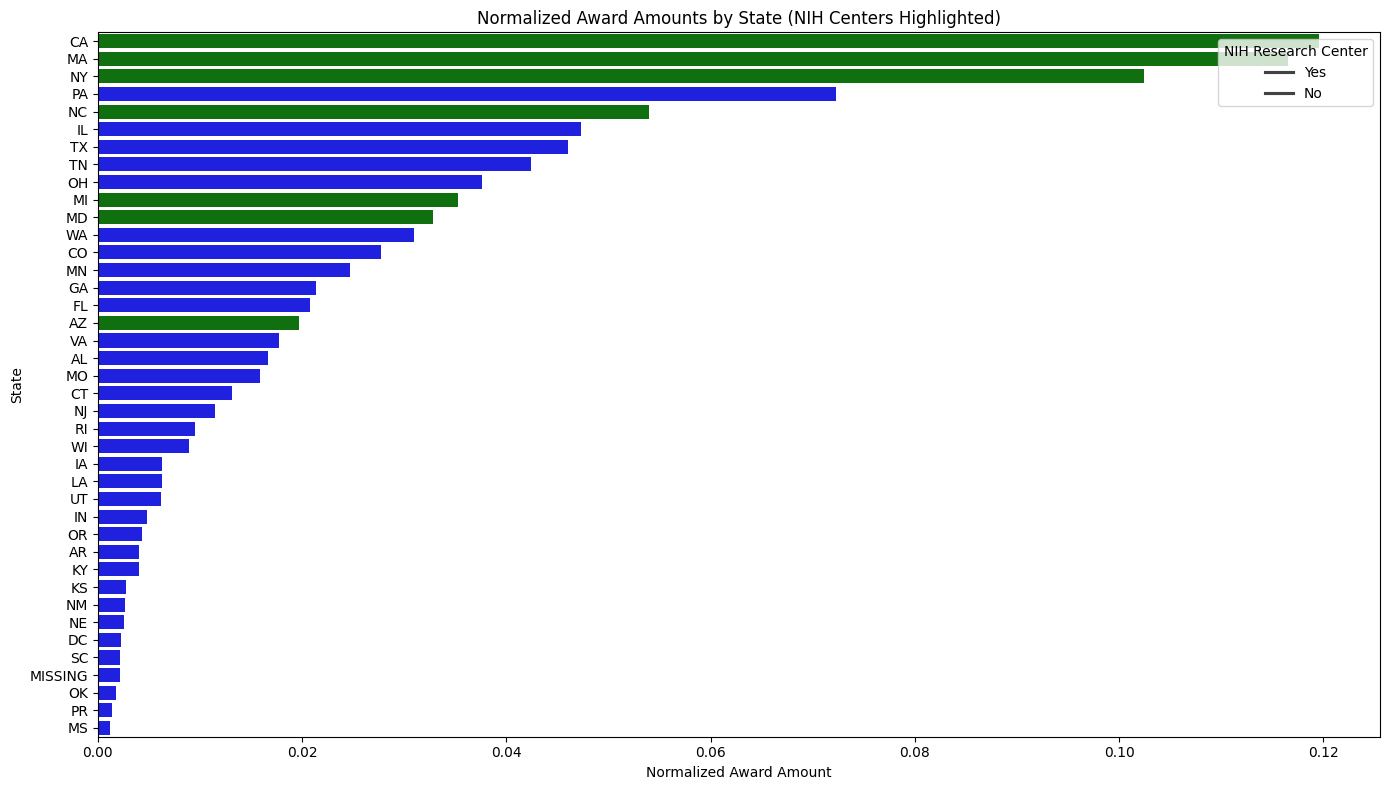

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Provided array of state data
state_data = ['TX', 'CT', 'NY', 'CA', 'NC', 'MA', 'GA', 'CO', 'FL', 'PA', 'OH',
              'AZ', 'MO', 'IN', 'WA', 'AR', 'AL', 'RI', 'MI', 'TN', 'UT', 'MD',
              'MN', 'VA', 'IA', 'IL', 'KS', 'OR', 'KY', 'LA', 'NJ', 'MISSING',
              'WI', 'DC', 'NM', 'PR', 'OK', 'SC', 'MS', 'NE']

# States hosting NIH research centers
nih_research_states = ['MD', 'NC', 'MT', 'AZ', 'MA', 'CA', 'NY', 'MI']

# Replace missing values in 'org_state'
df_cleaned['org_state'] = df_cleaned['org_state'].fillna('MISSING')

# Add a column indicating if a state hosts an NIH research center
df_cleaned['NIH_Center'] = df_cleaned['org_state'].isin(nih_research_states)

# Calculate normalized award amounts
state_totals = df_cleaned.groupby('org_state')['award_amount'].sum().reset_index()
state_totals['Normalized_Award'] = state_totals['award_amount'] / state_totals['award_amount'].sum()

# Add NIH Center information
state_totals['NIH_Center'] = state_totals['org_state'].isin(nih_research_states)

# Plot normalized award amounts
plt.figure(figsize=(14, 8))
sns.barplot(
    data=state_totals.sort_values('Normalized_Award', ascending=False),
    x='Normalized_Award',
    y='org_state',
    hue='NIH_Center',
    dodge=False,
    palette={True: 'green', False: 'blue'}
)

# Customize the plot
plt.title("Normalized Award Amounts by State (NIH Centers Highlighted)")
plt.xlabel("Normalized Award Amount")
plt.ylabel("State")
plt.legend(title="NIH Research Center", loc='upper right', labels=["Yes", "No"])
plt.tight_layout()
plt.show()


<ipython-input-61-0c03f283d31b>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['Normalized_Award'] = df_top_10['award_amount'] / df_top_10['award_amount'].sum()


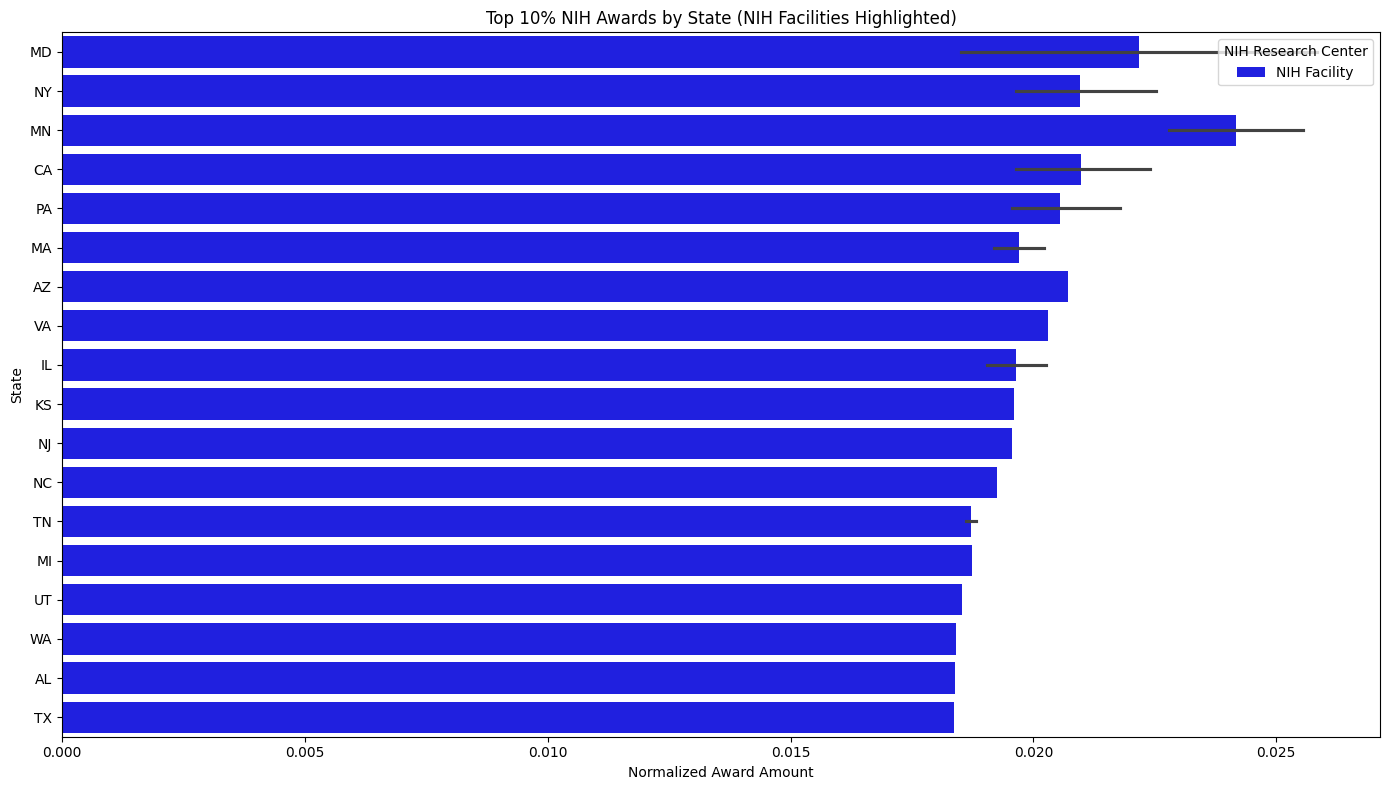

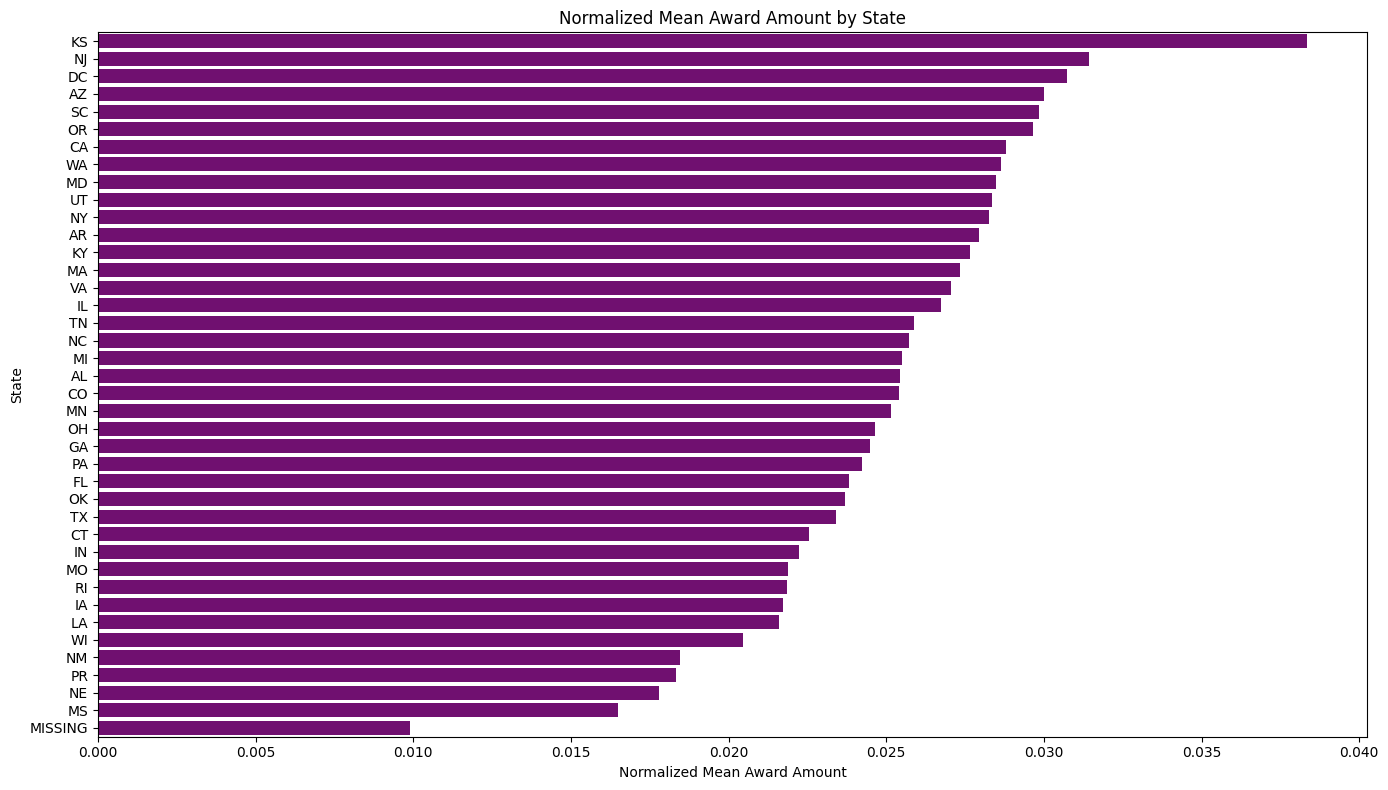

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace missing values in 'dept_type' and 'org_state' with 'MISSING'
df_cleaned['dept_type'] = df_cleaned['dept_type'].fillna('MISSING')
df_cleaned['org_state'] = df_cleaned['org_state'].fillna('MISSING')

# Step 1: Dynamically Identify NIH Research Center States
nih_research_states = [
    "Maryland", "North Carolina", "Montana", "Arizona",
    "Massachusetts", "California", "New York", "Michigan"
]

# Add a column indicating if a state hosts an NIH research center
df_cleaned['NIH_Center'] = df_cleaned['org_state'].str.upper().isin([state.upper() for state in nih_research_states])

# Step 2: Exclude outliers using IQR
def calculate_outlier_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower_bound, upper_bound = calculate_outlier_bounds(df_cleaned, 'award_amount')
df_no_outliers = df_cleaned[(df_cleaned['award_amount'] >= lower_bound) &
                            (df_cleaned['award_amount'] <= upper_bound)]

# Step 3: Filter for top 10% based on award amount
top_10_cutoff = df_no_outliers['award_amount'].quantile(0.9)
df_top_10 = df_no_outliers[df_no_outliers['award_amount'] >= top_10_cutoff]

# Step 4: Normalize award amounts for top 10% data
df_top_10['Normalized_Award'] = df_top_10['award_amount'] / df_top_10['award_amount'].sum()

# Step 5: Calculate expected mean award amount per state
state_means = df_no_outliers.groupby('org_state')['award_amount'].mean().reset_index()
state_means['Normalized_Mean_Award'] = state_means['award_amount'] / state_means['award_amount'].sum()

# Step 6: Plot top 10% awards with NIH Research Center Highlight
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_top_10.sort_values('Normalized_Award', ascending=False),
    x='Normalized_Award',
    y='org_state',
    hue='NIH_Center',
    dodge=False,
    palette={True: 'green', False: 'blue'}
)

# Customize the plot
plt.title("Top 10% NIH Awards by State (NIH Facilities Highlighted)")
plt.xlabel("Normalized Award Amount")
plt.ylabel("State")

# Fix the legend labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["NIH Facility", "Non-NIH Facility"], title="NIH Research Center", loc='upper right')

# Annotate NIH center states
for i, row in df_top_10.iterrows():
    if row['NIH_Center']:
        plt.text(
            i,
            row['Normalized_Award'] + 0.02,
            'NIH Facility',
            color='green',
            fontsize=10,
            ha='center'
        )

plt.tight_layout()
plt.show()

# Step 7: Plot normalized mean award amounts
plt.figure(figsize=(14, 8))
sns.barplot(
    data=state_means.sort_values('Normalized_Mean_Award', ascending=False),
    x='Normalized_Mean_Award',
    y='org_state',
    color='purple'
)

# Customize the plot
plt.title("Normalized Mean Award Amount by State")
plt.xlabel("Normalized Mean Award Amount")
plt.ylabel("State")

plt.tight_layout()
plt.show()



## Integrate AI Model (AI-Powered Insights) ##

In [24]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "None")


CUDA available: False
Device count: 0
Current device: None


In [25]:
# Load the text generation pipeline
generator = pipeline(
    "text-generation",
    model="bigscience/bloom-1b7",   #Alternative models:  bigscience/bloom-1b7, EleutherAI/gpt-neo-1.3B , sshleifer/distilbart-cnn-12-6
                                       #, distilbert-base-uncased-finetuned-sst-2-english
    return_full_text=False,
    device=-1                               #device = -1 for CPU and 0 for GPU
)


In [31]:
  # Extract the project_title column into a list
  project_titles = outliers['project_title'].dropna().tolist()

  # Combine all titles into a single prompt
  combined_titles = " ".join([f"- {title}" for title in project_titles])
  input_text = (
      f"{combined_titles} all fall under the research umbrella of.\n\n"

  )




In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Sort titles by funding first
outliers_sorted = outliers.sort_values(by="award_amount", ascending=False)
project_titles = outliers_sorted['project_title'].dropna().tolist()

# Combine all titles into one large text for processing
combined_titles = " ".join(project_titles)

# ===========================
# 1. Extract Top Terms Across All Titles
# ===========================

# Let the user specify the number of top terms to extract
num_top_terms = int(input("Enter the number of top terms to extract (e.g., 3, 5, 10): "))
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform([combined_titles])  # Single document containing all titles
terms = vectorizer.get_feature_names_out()
term_frequencies = Counter(dict(zip(terms, X.toarray()[0])))

# Extract the specified number of top terms
top_terms = term_frequencies.most_common(num_top_terms)
print(f"\nTop {num_top_terms} Most Common Terms Across All Titles:")
for idx, (term, count) in enumerate(top_terms, start=1):
    print(f"{idx}. {term} (Count: {count})")

# ===========================
# 2. Manual Prompt Creation
# ===========================

# Allow manual input for the final terms to use in the prompt
selected_terms = input("Enter the term(s) you'd like to focus on for the API prompt (comma-separated): ").split(",")

# Generate the prompt
selected_terms_str = ", ".join([term.strip() for term in selected_terms])
input_text = f"{selected_terms_str} research receives the most funding because"
print("\nGenerated Prompt:")
print(input_text)

# ===========================
# Optional: Insights on Terms
# ===========================
# Print additional context for selected terms
print("\nAdditional Insights:")
for term in selected_terms:
    count = term_frequencies.get(term.strip().lower(), 0)
    print(f"Term '{term.strip()}': Appears {count} times in the titles.")


Enter the number of top terms to extract (e.g., 3, 5, 10): 10

Top 10 Most Common Terms Across All Titles:
1. study (Count: 3)
2. ad (Count: 2)
3. aging (Count: 2)
4. associated (Count: 2)
5. early (Count: 2)
6. icu (Count: 2)
7. influenza (Count: 2)
8. patients (Count: 2)
9. risk (Count: 2)
10. targeting (Count: 2)
Enter the term(s) you'd like to focus on for the API prompt (comma-separated): aging

Generated Prompt:
aging research receives the most funding because

Additional Insights:
Term 'aging': Appears 2 times in the titles.


In [63]:
# Generate AI response
result = generator(input_text, max_new_tokens=300, num_return_sequences=1, truncation=True)

# Print the result
print("Input Prompt:", input_text)
print("Generated Text:", result[0]['generated_text'])


Input Prompt: aging research receives the most funding because
Generated Text:  it is the most difficult to conduct. The most common funding sources are the National Institutes of Health, the National Science Foundation, and the National Science Foundation. The National Institutes of Health is the largest funding source for research in the field of aging. The National Science Foundation is the second largest funding source for research in the field of aging. The National Science Foundation is the largest funding source for research in the field of aging. The National Science Foundation is the largest funding source for research in the field of aging. The National Science Foundation is the largest funding source for research in the field of aging. The National Science Foundation is the largest funding source for research in the field of aging. The National Science Foundation is the largest funding source for research in the field of aging. The National Science Foundation is the largest 

The response generated by the API is that aging research funding recieved the most funding because it is the most difficult to conduct. And that The most common funding sources are the National Institutes of Health, the National Science Foundation, and the National Science Foundation.